https://arxiv.org/abs/1905.02244

#### MobileNet V3
MobileNet V3ではMobileNet V2で導入したbottleneck構造に,SENetなどで導入したSE(Squeeze and Excitation) blockを組み合わせます。
また、非線形関数としては**h-swish**を使用します。
SE blockでは非線形関数としてhard-sigmoidを使い、expansion layerのチャンネル数は入力の1/4とします。

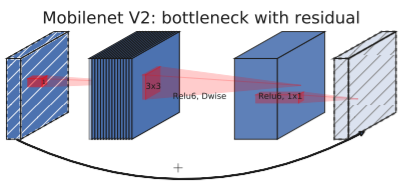

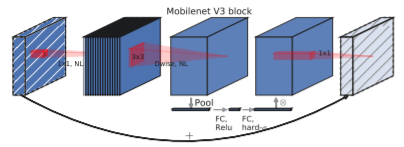

#### h-swish
**swish関数**は以下のように定義されます。
$$
swish(x)=x・\sigma(x)
$$

$\sigma(x)$はsigmoid関数を表します。
このsigmoid関数を、**hard-sigmoid**関数
$$
hard sigmoid(x)=RELU_6(x+3)/6
$$
で置き換えたものを**hard-swish関数**と呼びます。
$$
hardswish(x)=x\frac{RELU_6(x+3)}{6}
$$

ここで、$RELU_6$はMobileNet V2でも出てきましたが最大値を6としたRELU関数のことです。

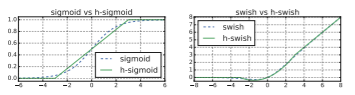

#### 構造
構造を見ていきます。
exp_sizeはbottleneck blockの中間層でのチャンネル数、outは出力のチャンネル数、SEはSE blockの有無、NLは使用する非線形関数(HSならh-swish,REならRELU)、sはstrideを表します。
NBNはBatchNormalizationのことです。

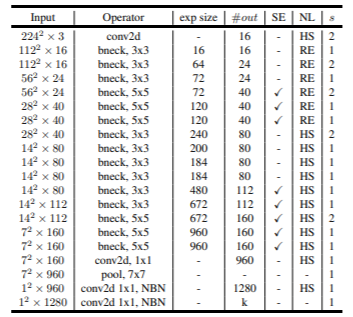

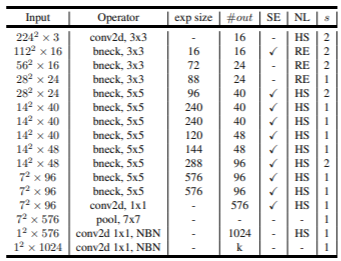

#### 学習
最適化手法はRMSpropでmomentumが0.9とします。学習率の初期値は0.1で3エポックごとに0.01の減衰率で減衰させます。weight decayは0.00001とします。
確率0.8のdropout層も挿入し、すべての畳み込み層の後にはBatchNormalizationを入れることとします。

#### 実装
MobileNet V2にSE blockの追加をして、非線形関数を変更するだけです。
(シリーズものでは自分の実装を持っておくとこの辺が楽だなと思いました。)

In [109]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Add, Multiply, ReLU
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [110]:
def hard_sigmoid(x):
    return ReLU(6.)(x + 3.) * (1. / 6.)

def hard_swish(x):
    return Multiply()([Activation(hard_sigmoid)(x), x])

In [111]:
class SE_Block(Model):
    def __init__(self, in_channels, r=0.25):
        super().__init__()
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(int(in_channels*r))
        self.relu = Activation(hard_sigmoid)
        self.fc2 = Dense(in_channels, activation='sigmoid')
    
    def call(self, x):
        out = self.pool(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out *= x
        return out

In [112]:
class mobilenetv3_block(Model):
    def __init__(self, exp_size, out_channels, kernel, SE, NL, s, r=0.25):
        super().__init__()        
        if NL == 'HS':
            activation = hard_swish
        else:
            activation = "relu"
        
        self.conv1 = Conv2D(filters = exp_size, kernel_size = (1,1), padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(activation)
    
        self.conv2 = DepthwiseConv2D(kernel_size = kernel, strides=s, padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(activation)

        self.conv3 = Conv2D(filters = out_channels, kernel_size = (1,1), padding = 'same')
        self.bn3 = BatchNormalization()
        self.relu3 = Activation(activation)
        
        if SE:
            self.se = SE_Block(in_channels=out_channels, r=r)
        else:
            self.se = None
        
        self.add = Add()
    
    def call(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        
        if self.se:
            out = self.se(out)
        
        if K.int_shape(out) == K.int_shape(x):
            out = self.add([out, x])
        
        return out

In [113]:
class MobileNetV3_Large(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(16, kernel_size=3, strides=2, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(hard_swish)
        
        self.bneck1  = mobilenetv3_block(exp_size=16,  out_channels=16,  kernel=3, SE=False, NL='RE', s=1)
        self.bneck2  = mobilenetv3_block(exp_size=64,  out_channels=24,  kernel=3, SE=False, NL='RE', s=2)
        self.bneck3  = mobilenetv3_block(exp_size=72,  out_channels=24,  kernel=3, SE=False, NL='RE', s=1)
        self.bneck4  = mobilenetv3_block(exp_size=72,  out_channels=40,  kernel=5, SE=True,  NL='RE', s=2)
        self.bneck5  = mobilenetv3_block(exp_size=120, out_channels=40,  kernel=5, SE=True,  NL='RE', s=1)
        self.bneck6  = mobilenetv3_block(exp_size=120, out_channels=40,  kernel=5, SE=True,  NL='RE', s=1)
        self.bneck7  = mobilenetv3_block(exp_size=240, out_channels=80,  kernel=3, SE=False, NL='HS', s=2)
        self.bneck8  = mobilenetv3_block(exp_size=200, out_channels=80,  kernel=3, SE=False, NL='HS', s=1)
        self.bneck9  = mobilenetv3_block(exp_size=184, out_channels=80,  kernel=3, SE=False, NL='HS', s=1)
        self.bneck10 = mobilenetv3_block(exp_size=184, out_channels=80,  kernel=3, SE=False, NL='HS', s=1)
        self.bneck11 = mobilenetv3_block(exp_size=480, out_channels=112, kernel=3, SE=True,  NL='HS', s=1)
        self.bneck12 = mobilenetv3_block(exp_size=672, out_channels=112, kernel=3, SE=True,  NL='HS', s=1)
        self.bneck13 = mobilenetv3_block(exp_size=672, out_channels=160, kernel=5, SE=True,  NL='HS', s=2)
        self.bneck14 = mobilenetv3_block(exp_size=960, out_channels=160, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck15 = mobilenetv3_block(exp_size=960, out_channels=160, kernel=5, SE=True,  NL='HS', s=1)
        
        self.conv2 = Conv2D(960, kernel_size=1, strides=1, padding='same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(hard_swish)
        
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(1280)
        self.relu3 = Activation(hard_swish)
        self.fc2 = Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.bneck1(x)
        x = self.bneck2(x)
        x = self.bneck3(x)
        x = self.bneck4(x)
        x = self.bneck5(x)
        x = self.bneck6(x)
        x = self.bneck7(x)
        x = self.bneck8(x)
        x = self.bneck9(x)
        x = self.bneck10(x)
        x = self.bneck11(x)
        x = self.bneck12(x)
        x = self.bneck13(x)
        x = self.bneck14(x)
        x = self.bneck15(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [116]:
class MobileNetV3_Small(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(16, kernel_size=3, strides=2, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(hard_swish)
        
        self.bneck1  = mobilenetv3_block(exp_size=16,  out_channels=16, kernel=3, SE=True,  NL='RE', s=2)
        self.bneck2  = mobilenetv3_block(exp_size=72,  out_channels=24, kernel=3, SE=False, NL='RE', s=2)
        self.bneck3  = mobilenetv3_block(exp_size=88,  out_channels=24, kernel=3, SE=False, NL='RE', s=1)
        self.bneck4  = mobilenetv3_block(exp_size=96,  out_channels=40, kernel=5, SE=True,  NL='HS', s=2)
        self.bneck5  = mobilenetv3_block(exp_size=240, out_channels=40, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck6  = mobilenetv3_block(exp_size=240, out_channels=40, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck7  = mobilenetv3_block(exp_size=120, out_channels=48, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck8  = mobilenetv3_block(exp_size=144, out_channels=48, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck9  = mobilenetv3_block(exp_size=288, out_channels=96, kernel=5, SE=True,  NL='HS', s=2)
        self.bneck10 = mobilenetv3_block(exp_size=576, out_channels=96, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck11 = mobilenetv3_block(exp_size=576, out_channels=96, kernel=5, SE=True,  NL='HS', s=1)
       
        self.conv2 = Conv2D(576, kernel_size=1, strides=1, padding='same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(hard_swish)
        
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(1024)
        self.relu3 = Activation(hard_sigmoid)
        self.fc2 = Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.bneck1(x)
        x = self.bneck2(x)
        x = self.bneck3(x)
        x = self.bneck4(x)
        x = self.bneck5(x)
        x = self.bneck6(x)
        x = self.bneck7(x)
        x = self.bneck8(x)
        x = self.bneck9(x)
        x = self.bneck10(x)
        x = self.bneck11(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [117]:
model = MobileNetV3_Small()
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 112, 112, 16)      448       
_________________________________________________________________
batch_normalization_216 (Bat (None, 112, 112, 16)      64        
_________________________________________________________________
activation_258 (Activation)  (None, 112, 112, 16)      0         
_________________________________________________________________
mobilenetv3_block_68 (mobile (None, 56, 56, 16)        1044      
_________________________________________________________________
mobilenetv3_block_69 (mobile (None, 28, 28, 24)        4368      
_________________________________________________________________
mobilenetv3_block_70 (mobile (None, 28, 28, 24)      

In [ ]:
epochs = 100
initial_lrate = 0.1

def decay(epoch, steps=100):
    initial_lrate = 0.1
    drop = 0.99
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=initial_lrate, rho=0.9, epsilon=1.0, decay=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = MobileNetV1()
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [104]:
?RMSprop

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [98]:
class SE_Block(nn.Module):
    def __init__(self, in_channels, r):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(in_channels, int(in_channels*r))
        self.relu = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(int(in_channels*r), in_channels)
        self.sigmoid = nn.Hardsigmoid()
    
    def forward(self, x):
        out = self.pool(x)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.shape[0], out.shape[1], 1,1).expand_as(x)
        return out * x

In [99]:
class mobilenetv3_block(nn.Module):
    def __init__(self, in_channels, exp_size, out_channels, SE, NL, s, r=0.25):
        super().__init__()        
        if NL == 'HS':
            activation = nn.Hardswish
        else:
            activation = nn.ReLU
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=exp_size, kernel_size = 1)
        self.bn1 = nn.BatchNorm2d(exp_size)
        self.relu1 = activation(False)
    
        self.conv2 = nn.Conv2d(in_channels=exp_size, out_channels=exp_size, kernel_size = 3, stride=s, groups=exp_size, padding = 1)
        self.bn2 = nn.BatchNorm2d(exp_size)
        self.relu2 = activation(False)

        self.conv3 = nn.Conv2d(in_channels=exp_size, out_channels=out_channels, kernel_size = 1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = activation(False)
        
        if SE:
            self.se = SE_Block(in_channels=out_channels, r=r)
        else:
            self.se = None
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        
        if self.se:
            out = self.se(out)

        if out.shape == x.shape:
            out = out + x
        
        return out

In [100]:
class MobileNetV3_Large(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.Hardswish()
        
        self.bneck1  = mobilenetv3_block(in_channels=16,  exp_size=16,  out_channels=16,  SE=False, NL='RE', s=1)
        self.bneck2  = mobilenetv3_block(in_channels=16,  exp_size=64,  out_channels=24,  SE=False, NL='RE', s=2)
        self.bneck3  = mobilenetv3_block(in_channels=24,  exp_size=72,  out_channels=24,  SE=False, NL='RE', s=1)
        self.bneck4  = mobilenetv3_block(in_channels=24,  exp_size=72,  out_channels=40,  SE=True,  NL='RE', s=2)
        self.bneck5  = mobilenetv3_block(in_channels=40,  exp_size=120, out_channels=40,  SE=True,  NL='RE', s=1)
        self.bneck6  = mobilenetv3_block(in_channels=40,  exp_size=120, out_channels=40,  SE=True,  NL='RE', s=1)
        self.bneck7  = mobilenetv3_block(in_channels=40,  exp_size=240, out_channels=80,  SE=False, NL='HS', s=2)
        self.bneck8  = mobilenetv3_block(in_channels=80,  exp_size=200, out_channels=80,  SE=False, NL='HS', s=1)
        self.bneck9  = mobilenetv3_block(in_channels=80,  exp_size=184, out_channels=80,  SE=False, NL='HS', s=1)
        self.bneck10 = mobilenetv3_block(in_channels=80,  exp_size=184, out_channels=80,  SE=False, NL='HS', s=1)
        self.bneck11 = mobilenetv3_block(in_channels=80,  exp_size=480, out_channels=112, SE=True,  NL='HS', s=1)
        self.bneck12 = mobilenetv3_block(in_channels=112, exp_size=672, out_channels=112, SE=True,  NL='HS', s=1)
        self.bneck13 = mobilenetv3_block(in_channels=112, exp_size=672, out_channels=160, SE=True,  NL='HS', s=2)
        self.bneck14 = mobilenetv3_block(in_channels=160, exp_size=960, out_channels=160, SE=True,  NL='HS', s=1)
        self.bneck15 = mobilenetv3_block(in_channels=160, exp_size=960, out_channels=160, SE=True,  NL='HS', s=1)
        
        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(960)
        self.relu2 = nn.Hardswish()
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(960, 1280)
        self.relu3 = nn.Hardswish()
        self.fc2 = nn.Linear(1280, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.bneck1(x)
        x = self.bneck2(x)
        x = self.bneck3(x)
        x = self.bneck4(x)
        x = self.bneck5(x)
        x = self.bneck6(x)
        x = self.bneck7(x)
        x = self.bneck8(x)
        x = self.bneck9(x)
        x = self.bneck10(x)
        x = self.bneck11(x)
        x = self.bneck12(x)
        x = self.bneck13(x)
        x = self.bneck14(x)
        x = self.bneck15(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [101]:
class MobileNetV3_Small(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.Hardswish()
        
        self.bneck1  = mobilenetv3_block(in_channels=16, exp_size=16,  out_channels=16, SE=True,  NL='RE', s=2)
        self.bneck2  = mobilenetv3_block(in_channels=16, exp_size=72,  out_channels=24, SE=False, NL='RE', s=2)
        self.bneck3  = mobilenetv3_block(in_channels=24, exp_size=88,  out_channels=24, SE=False, NL='RE', s=1)
        self.bneck4  = mobilenetv3_block(in_channels=24, exp_size=96,  out_channels=40, SE=True,  NL='HS', s=2)
        self.bneck5  = mobilenetv3_block(in_channels=40, exp_size=240, out_channels=40, SE=True,  NL='HS', s=1)
        self.bneck6  = mobilenetv3_block(in_channels=40, exp_size=240, out_channels=40, SE=True,  NL='HS', s=1)
        self.bneck7  = mobilenetv3_block(in_channels=40, exp_size=120, out_channels=48, SE=True,  NL='HS', s=1)
        self.bneck8  = mobilenetv3_block(in_channels=48, exp_size=144, out_channels=48, SE=True,  NL='HS', s=1)
        self.bneck9  = mobilenetv3_block(in_channels=48, exp_size=288, out_channels=96, SE=True,  NL='HS', s=2)
        self.bneck10 = mobilenetv3_block(in_channels=96, exp_size=576, out_channels=96, SE=True,  NL='HS', s=1)
        self.bneck11 = mobilenetv3_block(in_channels=96, exp_size=576, out_channels=96, SE=True,  NL='HS', s=1)
        
        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(576)
        self.relu2 = nn.Hardswish()
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(576, 1024)
        self.relu3 = nn.Hardswish()
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.bneck1(x)
        x = self.bneck2(x)
        x = self.bneck3(x)
        x = self.bneck4(x)
        x = self.bneck5(x)
        x = self.bneck6(x)
        x = self.bneck7(x)
        x = self.bneck8(x)
        x = self.bneck9(x)
        x = self.bneck10(x)
        x = self.bneck11(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [102]:
from torchsummary import summary

summary(MobileNetV3_Small(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             272
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7           [-1, 16, 56, 56]             160
       BatchNorm2d-8           [-1, 16, 56, 56]              32
              ReLU-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 16, 56, 56]             272
      BatchNorm2d-11           [-1, 16, 56, 56]              32
             ReLU-12           [-1, 16, 56, 56]               0
AdaptiveAvgPool2d-13             [-1, 16, 1, 1]               0
           Linear-14                   

In [ ]:
class MobileNetV1Trainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MobileNetV3_Small()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.parameters(), lr=0.1, eps=1.0, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
torchvision.models.mobilenet_v3_large
torchvision.models.mobilenet_v3_small

In [107]:
from torchvision.models import mobilenet_v3_large
from torchvision.models import mobilenet_v3_small
Model = mobilenet_v3_small(pretrained=True)
Model

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\tanak/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r